In [2]:
import json
import pandas as pd
import numpy as np
from yome import Session
from yome.models import *
from yome.util import to_df, report, scale_color, mpl_setup
from yome.constants import (
    colors_by_number as colors,
    hatches_by_number as hatches,
)
import re
from sqlalchemy.orm import aliased
import itertools as it
import seaborn as sns

In [3]:
pd.set_option('display.max_colwidth', -1)

In [4]:
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [5]:
sns.set_style('ticks')

In [6]:
session = Session()

# Genes without b-number

In [7]:
# Genes b4309 pseudo in EcoGene
no_b_number = to_df(
    session.query(KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('kb_name'))
    .join(Knowledgebase)
    .filter(KnowledgebaseGene.gene_id == None)
)

In [8]:
no_b_number.groupby('kb_name').agg('count')

,primary_name,annotation_quality
kb_name,,
EcoCyc,61,61
UniProt,1,1


# Find locus tags with multiple genes

In [9]:
KnowledgebaseGene2 = aliased(KnowledgebaseGene)

In [10]:
duplicates = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene2.primary_name.label('primary_name2'),
                  Knowledgebase.name)
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(KnowledgebaseGene2, KnowledgebaseGene2.gene_id == Gene.id)
    .join(Knowledgebase, KnowledgebaseGene.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene2.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene.id != KnowledgebaseGene2.id)
)

In [11]:
duplicates

,locus_id,primary_name,primary_name2,name
0,b4581,ybeM,ybeH,UniProt
1,b4581,ybeH,ybeM,UniProt


# Kbase comparison plot
NOTE: 55 EcoCyc & 1 UniProt genes without a locus tag and 2 EcoCyc and 1 Uniprot genes with duplicated locus tags are ignored in this plot

In [12]:
kbases = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'))
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
)

In [13]:
# remove duplicate genes
kbases_unstacked = kbases.set_index(['locus_id', 'knowledgebase_name'])
kbases_unstacked = kbases_unstacked[~kbases_unstacked.index.duplicated(keep='first')]
kbases_unstacked = kbases_unstacked.drop('primary_name', axis=1).unstack()
kbases_unstacked.columns = kbases_unstacked.columns.droplevel(0)

In [14]:
# y-ome counts
kbases_unstacked['y-ome'].value_counts()

high        2802
low         1601
excluded    220 
Name: y-ome, dtype: int64

In [15]:
# get list of genes starting with y in EcoCyc
# high quality EcoCyc evidence should override everything, e.g. b0089 / ftsW 

In [16]:
ecocyc_names = {x[0]: x[1] for x in (
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'EcoCyc')
).all()}

In [17]:
def starts_y(row):
    primary_name = ecocyc_names.get(row.name, None)
    return 'low' if primary_name and primary_name.startswith('y') \
        else 'high' if primary_name \
        else None

In [18]:
kbases_unstacked['Starts with "y"'] = kbases_unstacked.apply(starts_y, axis=1)

In [19]:
levels = {
    None: -1,
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
}

In [20]:
kbases_plot = kbases_unstacked.applymap(lambda x: levels[x])

In [21]:
def make_bars(df_all, labels):
    df = df_all[labels].sort_values(by=labels)
    # create bars based on consecutive colors
    last_value = {kbase: None for kbase in labels}
    bars = {kbase: [] for kbase in labels}
    for locus_tag, row in df.iterrows():
        for kbase, value in row.iteritems():
            if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
                bars[kbase].append({'value': value, 'height': 1})
                last_value[kbase] = value
            else:
                bars[kbase][-1]['height'] += 1
    return [bars[x] for x in labels]

In [22]:
def plot_bars(bars, labels, figsize=(13, 11), text=False):
    fig, ax = plt.subplots(figsize=figsize)
    last_heights = [0 for _ in labels]
    for bar_list in it.zip_longest(*bars):
        left = [x + 0.1 for x in range(len(labels))]
        height = [x['height'] if x is not None else 0 for x in bar_list]
        bottom = last_heights
        last_heights = [x + y for x, y in zip(height, last_heights)]
        color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
        hatch = [hatches[x['value']] if x is not None else '' for x in bar_list]
        for l, h, b, c, ha in zip(left, height, bottom, color, hatch):
            ax.bar(l, h, bottom=b, color=c, hatch=ha, edgecolor=scale_color(c, 1.1))
        if text:
            for l, h, b in zip(left, height, bottom):
                if h > 0 and h < 50:
                    y = h / 2 + b
                    ax.annotate(h, xy=(l + 0.15, y), xytext=(l + 0.45, y + 120),
                                arrowprops=dict(facecolor='black', width=1, headwidth=7),
                                verticalalignment='center',
                                color=(0.2,0.2,0.2))
                elif h > 50:
                    y = h + b - (110 if h > 120 else 80 if h > 100 else 30)
                    ax.text(l, y, str(h), horizontalalignment='center', 
                            color=(0.2,0.2,0.2))
    ax.set_xlabel('Knowledgebase')
    ax.set_ylabel('Gene')
    ax.xaxis.set_ticks([x + 0.1 for x in range(len(labels))])
    ax.xaxis.set_ticklabels(labels)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return fig, ax

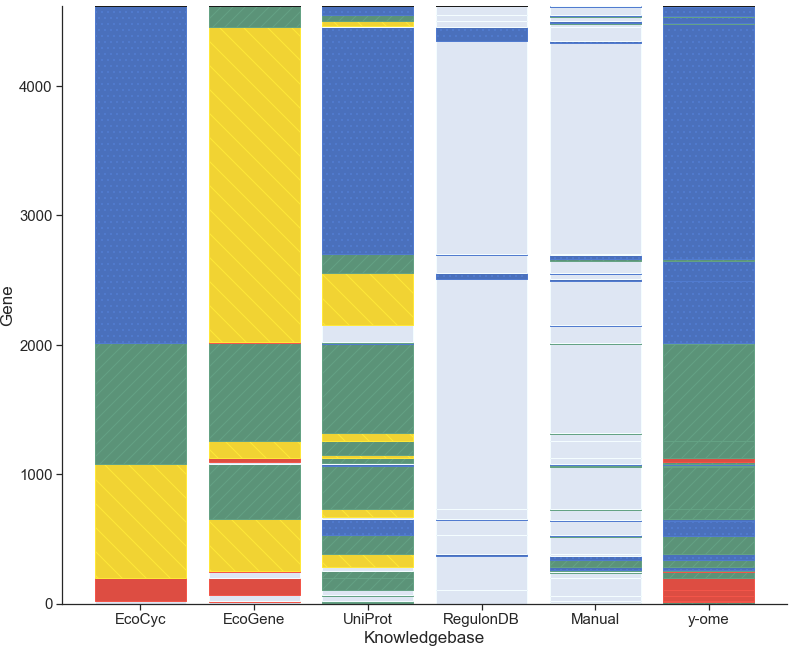

In [23]:
labels = ['EcoCyc', 'EcoGene', 'UniProt', 'RegulonDB', 'Manual', 'y-ome']
kbase_bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(kbase_bars, labels)
fig.savefig('/Users/zaking/lab/y-ome/figs/kbase-bars.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/kbase-bars.png')

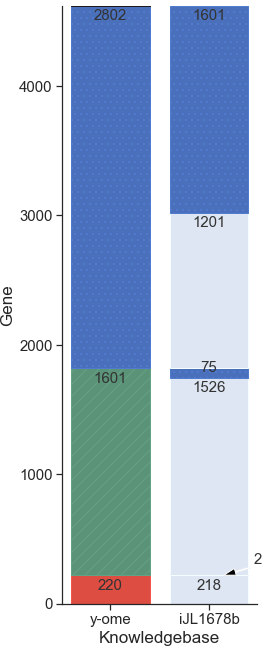

In [24]:
labels = ['y-ome', 'iJL1678b']
bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(bars, labels, figsize=(3.5, 11), text=True)
fig.savefig('/Users/zaking/lab/y-ome/figs/me-model-bars.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/me-model-bars.png')

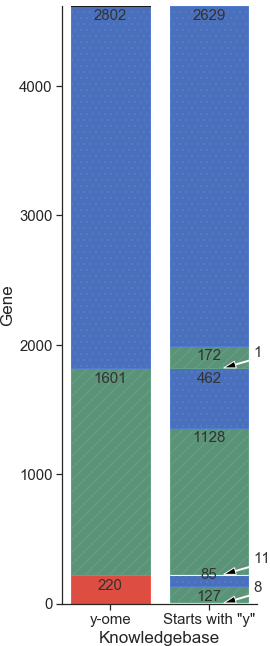

In [25]:
labels = ['y-ome', 'Starts with "y"']
bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(bars, labels, figsize=(3.5, 11), text=True)
fig.savefig('/Users/zaking/lab/y-ome/figs/starts-y-bars.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/starts-y-bars.png')

## Assertions
The literature points to a particular answer for these genes

In [26]:
assertions = pd.read_table('../sources/manual/manual.tsv', sep='\t', index_col='locus_tag')

# these differences check out
# ok = ['b0268', 'b1695', 'b2844', 'b0240', 'b4453']

# Check for any incorrect assertions
def check_for_row(row):
    return any(row.name == locus_tag and row['y-ome'] != val and row['y-ome'] != 'tbd' and val != 'read' and locus_tag not in ok
               for locus_tag, val in assertions.annotation_quality.items())
res = kbases_unstacked[kbases_unstacked.apply(check_for_row, axis=1)]
print(res)
assert(len(res) == 0)

Empty DataFrame
Columns: [EcoCyc, EcoGene, Manual, RefSeq, RegulonDB, UniProt, iJL1678b, y-ome, Starts with "y"]
Index: []


In [27]:
tbd = kbases_unstacked[(kbases_unstacked['y-ome'] == 'tbd') & ~kbases_unstacked.index.isin(assertions.index)]
# tbd_locus_tag = tbd.index[1]
# print(f'{len(tbd)} genes; next locus: {tbd_locus_tag}')

# kbases_unstacked[kbases_unstacked.index == tbd_locus_tag]

In [28]:
tbd

knowledgebase_name,EcoCyc,EcoGene,Manual,RefSeq,RegulonDB,UniProt,iJL1678b,y-ome,"Starts with ""y"""
locus_id,,,,,,,,,


# check on evidence type

In [29]:
ev = to_df(
    session.query(
        Gene.locus_id,
        KnowledgebaseGene.primary_name,
        KnowledgebaseFeature.feature,
    )
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
    .filter(KnowledgebaseFeature.feature.ilike('%domain-containing protein%'))
)

In [30]:
evm = ev.merge(kbases_unstacked, left_on='locus_id', right_index=True) #['y-ome'].value_counts()
evm[evm['y-ome'] == 'tbd']

,locus_id,primary_name,feature,EcoCyc,EcoGene,Manual,RefSeq,RegulonDB,UniProt,iJL1678b,y-ome,"Starts with ""y"""


# Compare to Hu et al. 2009

In [33]:
columns = {
#     'Gene': 'primary_name',
    'Bnumber': 'locus_tag',
    'Category': 'hu2009_category',
}

# Load data from Table S1
hu = pd.read_table('../sources/hu2009/table-s1-orphans.tsv.gz', compression='gzip').rename(columns=columns)
hu = hu.loc[:, hu.columns.isin(columns.values())]
hu.hu2009_category = hu.hu2009_category.map(lambda x: 'high' if x == 'annotated' else 'low')

hu.hu2009_category.value_counts()

high    2794
low     1431
Name: hu2009_category, dtype: int64

In [50]:
hu_combined = (kbases_unstacked.loc[:, ['y-ome', 'Starts with "y"']]
               .merge(hu, left_index=True, right_on='locus_tag')
               .set_index('locus_tag')
               .rename(columns={'hu2009_category': 'Hu et al. 2009'})
               .applymap(lambda x: levels[x]))

In [51]:
hu_combined.head()

,y-ome,"Starts with ""y""",Hu et al. 2009
locus_tag,,,
b0001,3,3,3
b0002,3,3,3
b0003,3,3,3
b0004,3,3,3
b0005,2,2,2


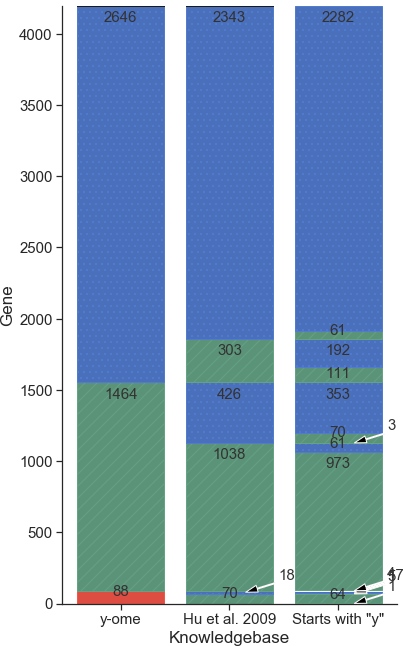

In [55]:
labels = ['y-ome', 'Hu et al. 2009', 'Starts with "y"']
bars = make_bars(hu_combined, labels)
fig, _ = plot_bars(bars, labels, figsize=(6, 11), text=True)
fig.savefig('/Users/zaking/lab/y-ome/figs/hu2009-comparison.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/hu2009-comparison.png')